<a href="https://colab.research.google.com/github/Gugo-le/school_record_/blob/main/sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 임베딩을 사용한 감성 프로그래밍

In [30]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !wget -q https://github.com/rickiepark/aiml4coders/raw/main/ch05/sarcasm.json
    !mkdir ../ch05
    !mv sarcasm.json ../ch05

mkdir: cannot create directory ‘../ch05’: File exists


In [31]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
import tensorflow as tf

In [32]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [33]:
with open("../ch05/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

<ipython-input-33-26e5c469036e>:13: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


In [34]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [35]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [36]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## 임베딩을 사용해 빈정거림 감지기 만들기

In [37]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [39]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [40]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5634 - loss: 0.6848 - val_accuracy: 0.5700 - val_loss: 0.6770
Epoch 2/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5802 - loss: 0.6720 - val_accuracy: 0.6535 - val_loss: 0.6390
Epoch 3/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7080 - loss: 0.5777 - val_accuracy: 0.7304 - val_loss: 0.5329
Epoch 4/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.7887 - loss: 0.4578 - val_accuracy: 0.7905 - val_loss: 0.4471
Epoch 5/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8151 - loss: 0.3993 - val_accuracy: 0.7867 - val_loss: 0.4547
Epoch 6/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8499 - loss: 0.3471 - val_accuracy: 0.8005 - val_loss: 0.4267
Epoch 7/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.8598 - loss: 0.3225 - val_accuracy: 0.8075 - val_loss: 0.4209
Epoch 8/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8673 - loss: 0.3071 - val_accuracy: 0.

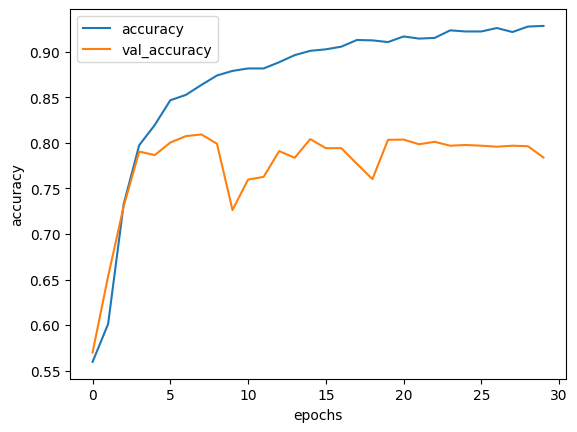

In [41]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

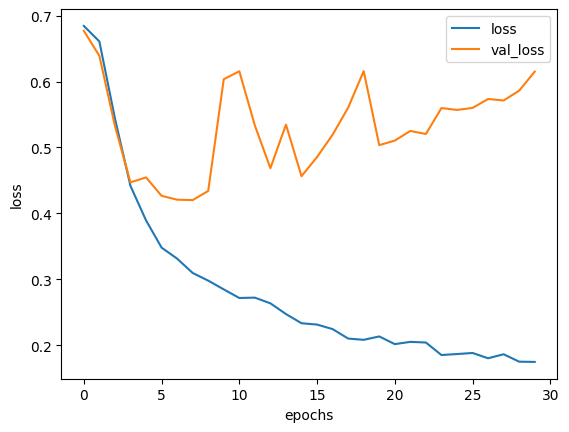

In [42]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## 언어 모델의 과대적합 줄이기

In [43]:
# 과대적함을 일으키는 가장 큰 요소는 옵티마이저의 학습률이 너무 높은 경우이다.(신경망이 너무 빠르게 학습한다는 의미)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001,
                               beta_1=0.9, beta_2=0.999, amsgrad=False) # amsgrad는 adam의 또 다른 구현,beta의 값은 0~1사이, 일반적으로 1에 가깝게 설정함.
model.compile(loss='binary_crossentropy',
              optimizer=adam, metrics=['accuracy'])

history = model.fit(training_padded, training_labels, epochs=100,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5536 - loss: 0.6885 - val_accuracy: 0.5700 - val_loss: 0.6825
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.5661 - loss: 0.6834 - val_accuracy: 0.5700 - val_loss: 0.6826
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5585 - loss: 0.6852 - val_accuracy: 0.5700 - val_loss: 0.6816
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5595 - loss: 0.6844 - val_accuracy: 0.5700 - val_loss: 0.6812
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5553 - loss: 0.6847 - val_accuracy: 0.5700 - val_loss: 0.6810
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5585 - loss: 0.6829 - val_accuracy: 0.5700 - val_loss: 0.6790
Epoch 7/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.5609 - loss: 0.6809 - val_accuracy: 0.5700 - val_loss: 0.6773
Epoch 8/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5596 - loss: 0.6791 - val_accu

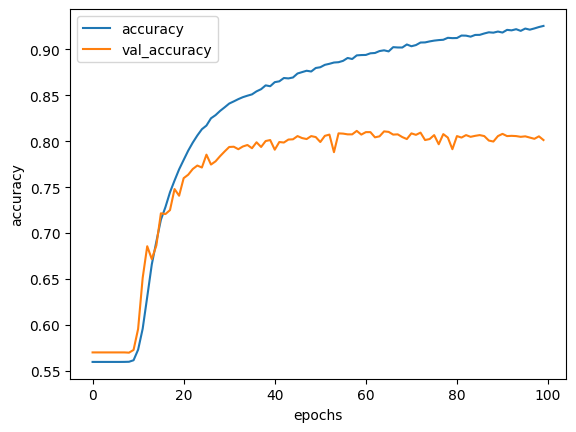

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

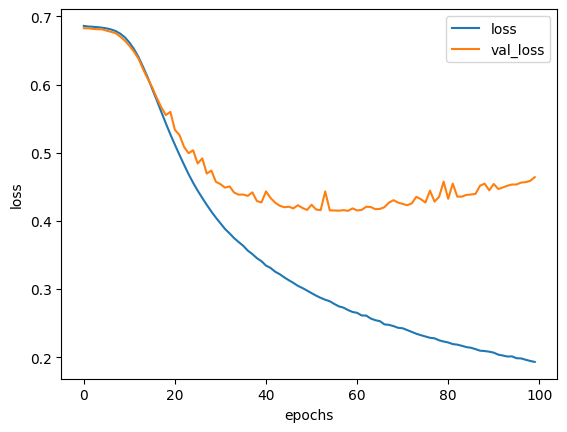

In [45]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

## 어휘 사전 크기 바꾸기

In [46]:
wc=tokenizer.word_counts
# 출력이 길어 노트북에서 제외함
print(wc)

OrderedDict([('former', 90), ('versace', 1), ('store', 44), ('clerk', 9), ('sues', 13), ('secret', 78), ('black', 230), ('code', 19), ('minority', 12), ('shoppers', 2), ('roseanne', 3), ('revival', 10), ('catches', 10), ('thorny', 3), ('political', 73), ('mood', 13), ('better', 100), ('worse', 34), ('mom', 163), ('starting', 37), ('fear', 39), ('sons', 35), ('web', 16), ('series', 53), ('closest', 5), ('thing', 126), ('will', 484), ('grandchild', 2), ('boehner', 26), ('just', 501), ('wants', 120), ('wife', 73), ('listen', 21), ('not', 634), ('come', 92), ('alternative', 13), ('debt', 23), ('reduction', 4), ('ideas', 35), ('j', 41), ('k', 39), ('rowling', 5), ('wishes', 33), ('snape', 2), ('happy', 51), ('birthday', 57), ('magical', 25), ('way', 239), ('advancing', 2), ('worlds', 79), ('women', 289), ('fascinating', 3), ('case', 77), ('eating', 64), ('lab', 8), ('grown', 17), ('meat', 25), ('ceo', 56), ('send', 33), ('kids', 164), ('school', 207), ('work', 168), ('company', 78), ('top',

In [47]:
from collections import OrderedDict
newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))
# 출력이 길어 노트북에서 제외함
print(newlist)

OrderedDict([('new', 1318), ('trump', 1117), ('man', 1075), ('not', 634), ('just', 501), ('will', 484), ('one', 469), ('year', 440), ('report', 434), ('area', 421), ('donald', 407), ('day', 398), ('u', 398), ('s', 392), ('can', 387), ('says', 385), ('woman', 378), ('first', 376), ('time', 365), ('like', 356), ('no', 352), ('get', 346), ('old', 332), ('trumps', 331), ('off', 326), ('now', 325), ('life', 319), ('obama', 317), ('people', 311), ('house', 290), ('women', 289), ('white', 281), ('back', 278), ('still', 276), ('make', 275), ('clinton', 264), ('5', 260), ('world', 251), ('americans', 246), ('years', 240), ('way', 239), ('family', 231), ('black', 230), ('study', 225), ('gop', 218), ('best', 215), ('bill', 211), ('american', 208), ('school', 207), ('police', 206), ('watch', 206), ('3', 205), ('show', 205), ('really', 200), ('president', 198), ('home', 196), ('last', 194), ('video', 194), ('finds', 194), ('death', 193), ('cant', 193), ('know', 193), ('10', 192), ('things', 191), (

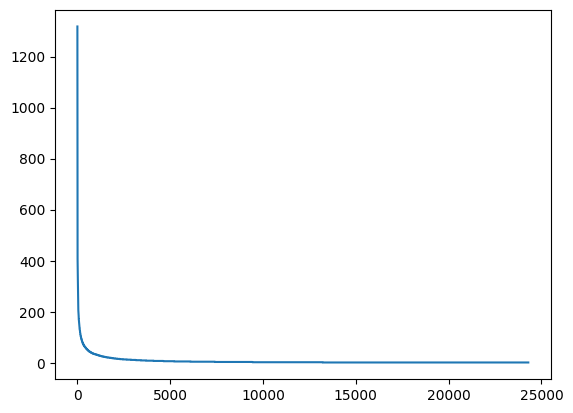

In [48]:
xs=[]
ys=[]
curr_x = 1
for item in newlist:
  xs.append(curr_x)
  curr_x=curr_x+1
  ys.append(newlist[item])

plt.plot(xs,ys)
plt.show()

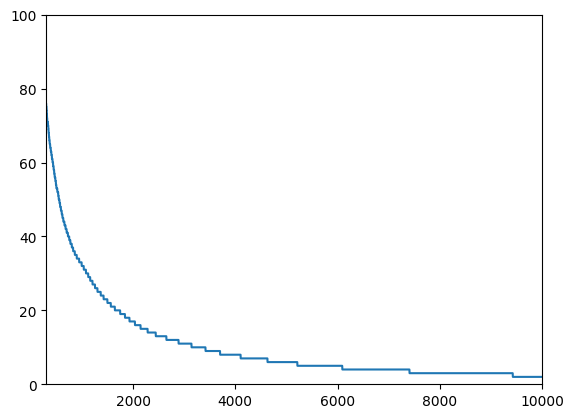

In [49]:
plt.plot(xs,ys)
plt.axis([300,10000,0,100])
plt.show()

In [50]:
vocab_size = 2000

In [51]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [52]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [53]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [54]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5590 - loss: 0.6863 - val_accuracy: 0.5700 - val_loss: 0.6777
Epoch 2/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5725 - loss: 0.6731 - val_accuracy: 0.6665 - val_loss: 0.6189
Epoch 3/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6814 - loss: 0.5958 - val_accuracy: 0.7269 - val_loss: 0.5375
Epoch 4/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7520 - loss: 0.5088 - val_accuracy: 0.6673 - val_loss: 0.5844
Epoch 5/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7630 - loss: 0.4865 - val_accuracy: 0.6870 - val_loss: 0.5578
Epoch 6/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7723 - loss: 0.4620 - val_accuracy: 0.6196 - val_loss: 0.6912
Epoch 7/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7767 - loss: 0.4608 - val_accuracy: 0.7727 - val_loss: 0.4649
Epoch 8/30
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7906 - loss: 0.4369 - val_accuracy: 0.

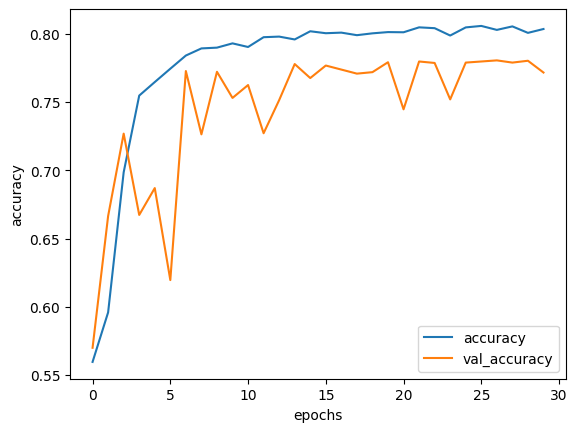

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

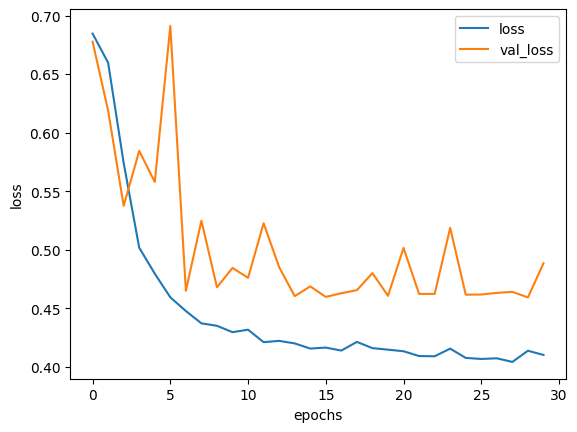

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

### 임베딩 차원 바꾸기

In [57]:
embedding_dim = 7

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5592 - loss: 0.6858 - val_accuracy: 0.5697 - val_loss: 0.6792
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5700 - loss: 0.6755 - val_accuracy: 0.6436 - val_loss: 0.6499
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6409 - loss: 0.6269 - val_accuracy: 0.7072 - val_loss: 0.5795
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7088 - loss: 0.5631 - val_accuracy: 0.7385 - val_loss: 0.5273
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7473 - loss: 0.5109 - val_accuracy: 0.7582 - val_loss: 0.4954
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7692 - loss: 0.4805 - val_accuracy: 0.7622 - val_loss: 0.4804
Epoch 7/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7758 - loss: 0.4622 - val_accuracy: 0.7665 - val_loss: 0.4734
Epoch 8/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7902 - loss: 0.4443 - val_accu

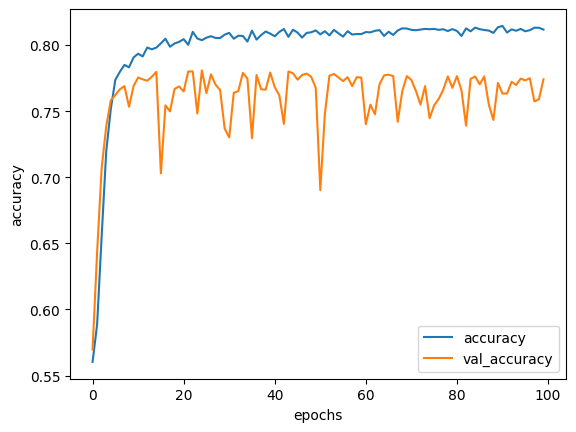

In [58]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

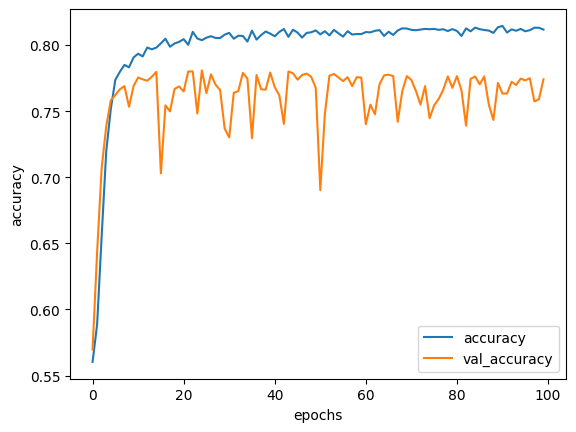

In [59]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

### 모델 구조 변경하기

In [60]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [61]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5570 - loss: 0.6868 - val_accuracy: 0.5700 - val_loss: 0.6810
Epoch 2/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5618 - loss: 0.6808 - val_accuracy: 0.5772 - val_loss: 0.6631
Epoch 3/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5984 - loss: 0.6598 - val_accuracy: 0.6231 - val_loss: 0.6281
Epoch 4/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6601 - loss: 0.6156 - val_accuracy: 0.6913 - val_loss: 0.5774
Epoch 5/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7161 - loss: 0.5596 - val_accuracy: 0.7374 - val_loss: 0.5380
Epoch 6/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7491 - loss: 0.5184 - val_accuracy: 0.7417 - val_loss: 0.5148
Epoch 7/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7708 - loss: 0.4852 - val_accuracy: 0.7185 - val_loss: 0.5479
Epoch 8/100
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7718 - loss: 0.4736 - val_accu

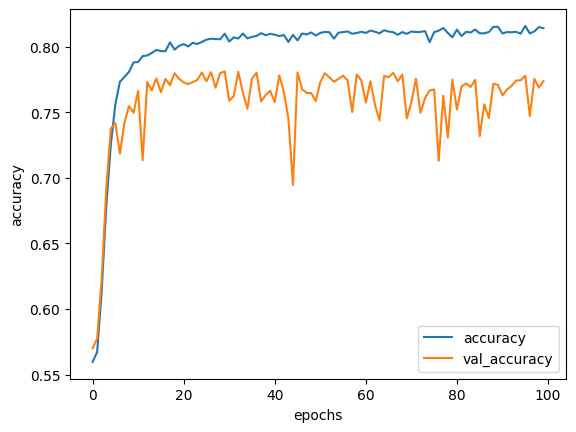

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

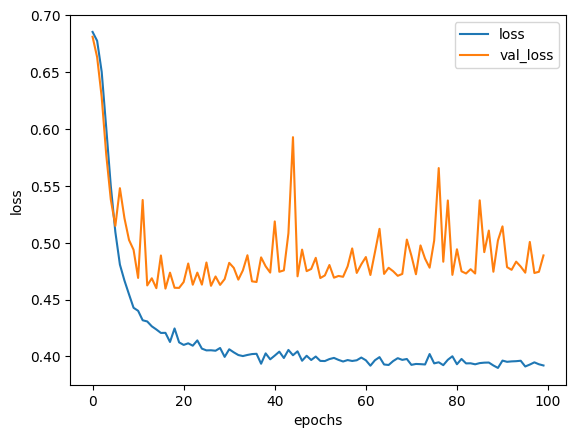

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

###